In [1]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/iprovilkov/data/JUNO/notebooks/')

In [2]:
from data_utils.data_processing import get_data_2dprojection
from data_utils.data_generator import DataGenerator

Using TensorFlow backend.


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100000,20000)
MAXR = 17200

In [22]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [23]:
model = Sequential()
model.add(L.Conv2D(filters= 32, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters= 64, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3), activation='elu'))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(1024, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
#model.add(L.Dropout(0.3))
model.add(L.Dense(512, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(256, activation='elu',kernel_initializer=keras.initializers.glorot_normal()))
model.add(L.Dense(1))

In [24]:
opt = Adam(decay=1e-4)

In [25]:
edge_size0 = 226
edge_size1 = 112
inputs = Input(shape=(edge_size0,edge_size1,2))

In [27]:
model.build(input_shape=(None, edge_size0,edge_size1,2))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 110, 32)      608       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 55, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 53, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 26, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 53, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 12, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 10, 256)       295168    
__________

In [37]:
model.compile(loss='mean_squared_error', optimizer=opt)

In [28]:
logdir = 'Simple_CNN_R.csv'

In [29]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau
csv_logger = CSVLogger(logdir, append=True, separator=';')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001)

In [30]:
TRAIN_DIR = '~/data/data_dir/'
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [39]:
X_test = np.load(LTRAIN + '_' + str(rg[-2]) +'without_noise_sin.npy')

In [40]:
y_test = tr_true_info[(tr_true_info['evtID'] >= rg[-2]) 
                     & (tr_true_info['evtID'] < rg[-1])]
mask = (y_test.R <= MAXR)
X_test = X_test[mask]
y_test = y_test[mask][['R']].values

In [42]:
def scaler(X,y):
    X[:,:,:,1] /= 20 
    y /= 10000

In [43]:
scaler(X_test, y_test)

In [44]:
training_generator = DataGenerator(16,rg=rg,
                                file_names=[LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]],
                                  y_true=tr_true_info,
                                  target_names=['R'],
                                  scaler=scaler)

In [45]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*15)

Epoch 1/60
1147/1147 [==============================] - 76s 66ms/step - loss: 217307.4093 - val_loss: 0.2236
Epoch 2/60
1147/1147 [==============================] - 74s 65ms/step - loss: 14.4105 - val_loss: 0.4584
Epoch 3/60
1147/1147 [==============================] - 74s 65ms/step - loss: 4.5316 - val_loss: 0.1222
Epoch 4/60
1147/1147 [==============================] - 74s 64ms/step - loss: 6.1546 - val_loss: 0.5509
Epoch 5/60
1147/1147 [==============================] - 74s 65ms/step - loss: 2.4473 - val_loss: 0.2792
Epoch 6/60
1147/1147 [==============================] - 74s 64ms/step - loss: 1.2429 - val_loss: 0.8710
Epoch 7/60
1147/1147 [==============================] - 74s 65ms/step - loss: 0.9741 - val_loss: 0.4646
Epoch 8/60
1147/1147 [==============================] - 74s 65ms/step - loss: 0.7848 - val_loss: 0.5048
Epoch 9/60
1147/1147 [==============================] - 74s 65ms/step - loss: 0.0930 - val_loss: 0.1038
Epoch 10/60
1147/1147 [==============================] - 7

In [119]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*5)

Epoch 1/20
1147/1147 [==============================] - 77s 67ms/step - loss: 2.9536e-04 - val_loss: 3.0687e-04
Epoch 2/20
1147/1147 [==============================] - 75s 65ms/step - loss: 3.0074e-04 - val_loss: 3.0771e-04
Epoch 3/20
1147/1147 [==============================] - 75s 65ms/step - loss: 2.9808e-04 - val_loss: 3.0726e-04
Epoch 4/20
1147/1147 [==============================] - 75s 65ms/step - loss: 2.9510e-04 - val_loss: 3.0697e-04
Epoch 5/20
1147/1147 [==============================] - 75s 65ms/step - loss: 3.0022e-04 - val_loss: 3.0668e-04
Epoch 6/20
1147/1147 [==============================] - 75s 65ms/step - loss: 2.9778e-04 - val_loss: 3.0700e-04
Epoch 7/20
1147/1147 [==============================] - 75s 65ms/step - loss: 2.9483e-04 - val_loss: 3.0756e-04
Epoch 8/20
1147/1147 [==============================] - 75s 65ms/step - loss: 3.0013e-04 - val_loss: 3.0729e-04
Epoch 9/20
1147/1147 [==============================] - 75s 65ms/step - loss: 2.9762e-04 - val_loss: 3.0

In [46]:
name = 'SimpleCNN-R'
model.save_weights(name + '.h5')
with open(name + ".json", "w") as json_file:
    json_file.write(model.to_json())

(0, 0.0005)

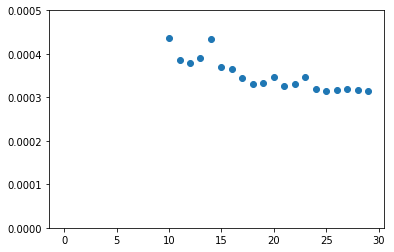

In [77]:
cs = pd.read_csv(logdir, sep=';')
cs = cs[-30:]
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,0.0005)

In [48]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [49]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

In [51]:
test_resultsE.mean() * 10000

3.1477582585813946

In [93]:
preds[:,0]

array([1.5115355 , 0.98990214, 1.6160734 , ..., 1.001525  , 0.9895013 ,
       0.9731051 ], dtype=float32)

In [95]:
np.std(preds[:,0]-y_test[:,0]) * 1000

17.729056464008437

In [54]:
from tqdm import tqdm

In [55]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [108]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                print("Compute...")
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits,
                                                None,
                                                pos,
                                                true_info,
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
                np.save(test_dir+str(energy)+'data_lpmt_without_noise_sin', data_lpmt)
            else:
                pass
            
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        y_test = true_info[test_column].values
        
        scaler(data_lpmt, y_test)
        
        preds = np.maximum(model.predict(data_lpmt), 0).reshape(-1)
        print(y_test.mean())
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(preds, y_test)
        # in percents
        if test_column == 'E':
            sigmas[energy] = np.std(preds - y_test) / (energy + CONST)
        if test_column == 'R':
            print(preds[:10])
            print(y_test[:10])
            sigmas[energy] = np.std(preds - y_test)
    print("+")
    return sigmas, MSEs, predictions

In [109]:
sigmas, MSEs, predictions = test_sigmas(model, test_column='R', time=True, recompute=False)

 10%|█         | 1/10 [00:02<00:19,  2.16s/it]

1.2992799344627193
[1.3935548 1.4074533 1.4647882 1.6431276 1.6712353 1.5852664 1.3214929
 1.5325754 1.22043   1.1547775]
[1.3685387 1.3767972 1.4483374 1.6385209 1.6535102 1.6292973 1.3321352
 1.4847134 1.2601948 1.2191814]


 20%|██        | 2/10 [00:04<00:16,  2.10s/it]

1.2795368531840796
[1.383608  1.3556687 0.9317264 1.3945394 1.0375874 0.8511879 1.5909028
 0.832404  0.6142629 1.4248064]
[1.3685387  1.3410883  0.9433555  1.3953234  0.9949386  0.8924891
 1.5597524  0.86869375 0.6877779  1.3697783 ]


 30%|███       | 3/10 [00:06<00:14,  2.05s/it]

1.2843427971888646
[1.3719547  0.95666796 1.47265    1.1292018  1.502877   0.9756976
 1.2822165  0.61436653 1.7023529  0.40906727]
[1.3685387  0.9459184  1.4780856  1.1244336  1.5168536  0.9857545
 1.3065209  0.57169985 1.7010791  0.37662598]


 40%|████      | 4/10 [00:08<00:12,  2.03s/it]

1.2948405061062433
[1.3668954 1.5522988 1.5019159 1.2251354 1.5229979 1.5500379 1.2896637
 1.3272849 1.2164596 1.5914813]
[1.3685387 1.5327389 1.4982    1.2146219 1.5341161 1.5562079 1.3139039
 1.3423874 1.20053   1.5854112]


 50%|█████     | 5/10 [00:10<00:10,  2.02s/it]

1.2828058873206523
[1.3690339  1.4373864  1.1333548  1.4127519  1.0461732  1.0530869
 1.3545331  0.83453625 1.1311456  1.5921683 ]
[1.3685387  1.4200797  1.120073   1.4083442  1.0510377  1.050041
 1.3247246  0.81587183 1.1431432  1.5828905 ]


 60%|██████    | 6/10 [00:12<00:08,  2.03s/it]

1.2889448278670954
[1.3708719 0.86245   1.2250825 1.6640694 1.1652019 1.5676265 1.6043727
 1.5984777 1.6712266 1.2018957]
[1.3685387 0.8422246 1.2181572 1.6394582 1.1673857 1.5601306 1.6126187
 1.6045935 1.6654432 1.2175233]


 70%|███████   | 7/10 [00:14<00:06,  2.00s/it]

1.274923923822563
[1.3528475 1.1679771 1.2289362 1.1744931 1.3587434 1.3870258 1.7032127
 1.0052104 1.2011447 1.2871721]
[1.3685387 1.1922321 1.2114285 1.1516515 1.3680285 1.3979825 1.7108254
 1.0130919 1.1991952 1.2682488]


 80%|████████  | 8/10 [00:15<00:03,  1.98s/it]

1.2876060249422123
[1.377006  1.3102227 1.4640114 1.3285916 1.7018483 1.4486407 1.2115979
 1.3707061 0.9144483 1.1849247]
[1.3685387 1.2958754 1.461241  1.3395118 1.714644  1.442213  1.1942524
 1.3709816 0.9141089 1.1901334]


 90%|█████████ | 9/10 [00:17<00:01,  1.99s/it]

1.281879364303728
[1.3632951  1.4510741  1.5688528  1.3278478  0.94992435 1.3436459
 0.4361966  0.9216401  1.0516486  0.9050406 ]
[1.3685387  1.4392851  1.5712894  1.33038545 0.953068   1.3284986
 0.4756147  0.9080496  1.0546205  0.9097196 ]


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

1.2875018456006495
[1.3516517  1.1024039  1.5627137  0.31870076 1.168768   1.6823391
 1.6721308  1.3024683  1.5280305  0.9663809 ]
[1.3685387 1.112992  1.5775158 0.2958306 1.173266  1.6947965 1.6712424
 1.304753  1.5077495 0.9472099]
+


In [120]:
sigmas[3] * 1000

17.11657548460994

In [122]:
sigmas, MSEs

({0: 0.035704540595533726,
  1: 0.023853240699417327,
  2: 0.01997321209923213,
  3: 0.017116575484609937,
  4: 0.01612598360762632,
  5: 0.015302441635937553,
  6: 0.01564519597586449,
  7: 0.014921523666398168,
  8: 0.014843100558073424,
  9: 0.01527234414355844},
 {0: 0.001274872802555039,
  1: 0.0005716101939442287,
  2: 0.00040050669814238317,
  3: 0.0002934479948763349,
  4: 0.0002628126918799006,
  5: 0.00023893426898796192,
  6: 0.0002475579100093479,
  7: 0.00022478328511739925,
  8: 0.00022317544010215073,
  9: 0.00023531307017163027})

In [78]:
a = 2.8
b=0.59
c=0

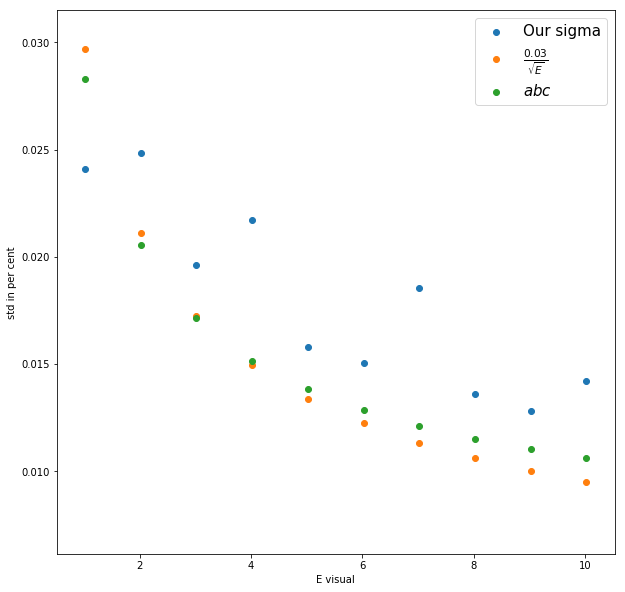

In [79]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)